In [1]:
# Import library yang dibutuhkan
import pandas as pd
from scipy.stats import skew, kurtosis
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
dataNormal = pd.read_csv("./ptbdb_normal.csv")
dataAbnormal = pd.read_csv("./ptbdb_abnormal.csv")
# Memeriksa jumlah data di masing-masing dataset
print("Jumlah data normal:", len(dataNormal))
print("Jumlah data abnormal:", len(dataAbnormal))

Jumlah data normal: 4045
Jumlah data abnormal: 10505


In [3]:
# Menambahkan kolom target: 0 untuk normal, 1 untuk abnormal
dataNormal['target'] = 0
dataAbnormal['target'] = 1

In [4]:
# Mengambil subset dari data abnormal agar jumlahnya sama dengan data normal
dataAbnormal_subset =dataAbnormal.sample(n=len(dataNormal), random_state=42)

# Memeriksa jumlah data setelah pengambilan subset
print("Jumlah data normal setelah subset:", len(dataNormal))
print("Jumlah data abnormal setelah subset:", len(dataAbnormal_subset))

Jumlah data normal setelah subset: 4045
Jumlah data abnormal setelah subset: 4045


In [5]:
# Menggabungkan data normal dan subset data abnormal
data_balanced = pd.concat([dataNormal, dataAbnormal_subset])

# Memeriksa jumlah data setelah digabung
print("Jumlah total data setelah digabung:", len(data_balanced))
print("Jumlah data per kelas setelah digabung:\n", data_balanced['target'].value_counts())

Jumlah total data setelah digabung: 8090
Jumlah data per kelas setelah digabung:
 target
0    4045
1    4045
Name: count, dtype: int64


In [6]:
# Memisahkan data menjadi 80% training dan 20% testing
train_data, test_data = train_test_split(data_balanced, test_size=0.2, random_state=42, stratify=data_balanced['target'])

# Memeriksa jumlah data training dan testing
print("Jumlah data training:", len(train_data))
print("Jumlah data testing:", len(test_data))
print("training 80% :\n", train_data['target'].value_counts())
print("testing 20% :\n", test_data['target'].value_counts())

Jumlah data training: 6472
Jumlah data testing: 1618
training 80% :
 target
0    3236
1    3236
Name: count, dtype: int64
testing 20% :
 target
0    809
1    809
Name: count, dtype: int64


In [7]:
# Memeriksa jumlah nilai kosong di setiap kolom
print("Jumlah nilai kosong di setiap kolom:")
print(data_balanced.isnull().sum())

# Menampilkan baris-baris yang memiliki nilai kosong, jika ada
print("\nBaris dengan nilai kosong:")
print(data_balanced[data_balanced.isnull().any(axis=1)])


Jumlah nilai kosong di setiap kolom:
1.000000000000000000e+00    4045
9.003241658210754395e-01    4045
3.585899472236633301e-01    4045
5.145867168903350830e-02    4045
4.659643396735191345e-02    4045
                            ... 
0.00E+00.122                4045
0.00E+00.123                4045
0.00E+00.124                4045
0.00E+00.125                4045
1.00E+00.1                  4045
Length: 377, dtype: int64

Baris dengan nilai kosong:
      1.000000000000000000e+00  9.003241658210754395e-01  \
0                     1.000000                  0.794681   
1                     0.909029                  0.791482   
2                     1.000000                  0.478893   
3                     1.000000                  0.867238   
4                     0.948983                  0.505265   
...                        ...                       ...   
5282                       NaN                       NaN   
9629                       NaN                       NaN   
9608  

In [8]:
# Menentukan ambang batas 50% dari jumlah total data
threshold = 0.5 * len(train_data)

# Menghapus kolom dengan lebih dari 50% data kosong di data training dan testing
train_data = train_data.dropna(thresh=threshold, axis=1)
test_data = test_data[train_data.columns]  # Menyamakan kolom test dengan train setelah penghapusan kolom

# Memeriksa kembali jumlah data kosong setelah penghapusan kolom
print("Jumlah nilai kosong di data training setelah penghapusan kolom:")
print(train_data.isnull().sum().sum())
print("Jumlah nilai kosong di data testing setelah penghapusan kolom:")
print(test_data.isnull().sum().sum())



Jumlah nilai kosong di data training setelah penghapusan kolom:
1216736
Jumlah nilai kosong di data testing setelah penghapusan kolom:
304184


In [9]:
# Mengisi data kosong di data training dan testing dengan nilai median kolom masing-masing
train_data = train_data.fillna(train_data.median())
test_data = test_data.fillna(test_data.median())

# Memeriksa kembali jumlah data kosong untuk memastikan semua nilai kosong sudah terisi
print("Setelah pengisian dengan median:")
print("Jumlah NaN di data training:", train_data.isnull().sum().sum())
print("Jumlah NaN di data testing:", test_data.isnull().sum().sum())


Setelah pengisian dengan median:
Jumlah NaN di data training: 0
Jumlah NaN di data testing: 0


In [10]:
# Fungsi untuk mengkalkulasi fitur dari Fourier Transform
def extract_fourier_features(signal):
    fft_values = np.abs(fft(signal))
    mean_fft = np.mean(fft_values)
    max_fft = np.max(fft_values)
    std_fft = np.std(fft_values)
    return mean_fft, max_fft, std_fft

### Ekstraksi Fourier

In [11]:
# Menerapkan ekstraksi Fourier pada data training
fourier_train_features = []
for _, row in train_data.iterrows():
    signal = row.drop('target').values  # Menghapus kolom target untuk mengambil sinyal
    mean_fft, max_fft, std_fft = extract_fourier_features(signal)
    fourier_train_features.append([mean_fft, max_fft, std_fft, row['target']])

# Membuat DataFrame untuk hasil ekstraksi fitur Fourier pada training
columns = ['mean_fft', 'max_fft', 'std_fft', 'target']
train_fourier_data = pd.DataFrame(fourier_train_features, columns=columns)

In [12]:
# Menerapkan ekstraksi Fourier pada data testing
fourier_test_features = []
for _, row in test_data.iterrows():
    signal = row.drop('target').values  # Menghapus kolom target untuk mengambil sinyal
    mean_fft, max_fft, std_fft = extract_fourier_features(signal)
    fourier_test_features.append([mean_fft, max_fft, std_fft, row['target']])

# Membuat DataFrame untuk hasil ekstraksi fitur Fourier pada testing
test_fourier_data = pd.DataFrame(fourier_test_features, columns=columns)

In [13]:
# Melihat beberapa baris hasil ekstraksi Fourier dari data training
print("Data training setelah ekstraksi Fourier:")
print(train_fourier_data)

# Melihat beberapa baris hasil ekstraksi Fourier dari data testing
print("\nData testing setelah ekstraksi Fourier:")
print(test_fourier_data)

Data training setelah ekstraksi Fourier:
      mean_fft    max_fft   std_fft  target
0     2.223622  71.931709  4.628608     0.0
1     2.140512  60.350456  4.184251     0.0
2     2.037335  47.283346  3.226085     0.0
3     2.011399  54.719820  3.469665     1.0
4     2.026559  53.945443  3.503521     0.0
...        ...        ...       ...     ...
6467  1.997844  46.045950  3.154239     1.0
6468  2.306365  75.258732  4.633418     0.0
6469  2.083272  45.139414  3.100461     0.0
6470  2.114245  60.900137  3.881766     0.0
6471  2.403127  62.726220  4.374854     1.0

[6472 rows x 4 columns]

Data testing setelah ekstraksi Fourier:
      mean_fft    max_fft   std_fft  target
0     2.049396  54.826054  3.569516     0.0
1     2.179035  82.312633  5.377823     0.0
2     2.197838  53.887364  3.521274     1.0
3     2.258791  78.488224  5.119841     1.0
4     2.081755  53.633764  3.484934     0.0
...        ...        ...       ...     ...
1613  2.096926  58.957834  3.800002     0.0
1614  2.39153

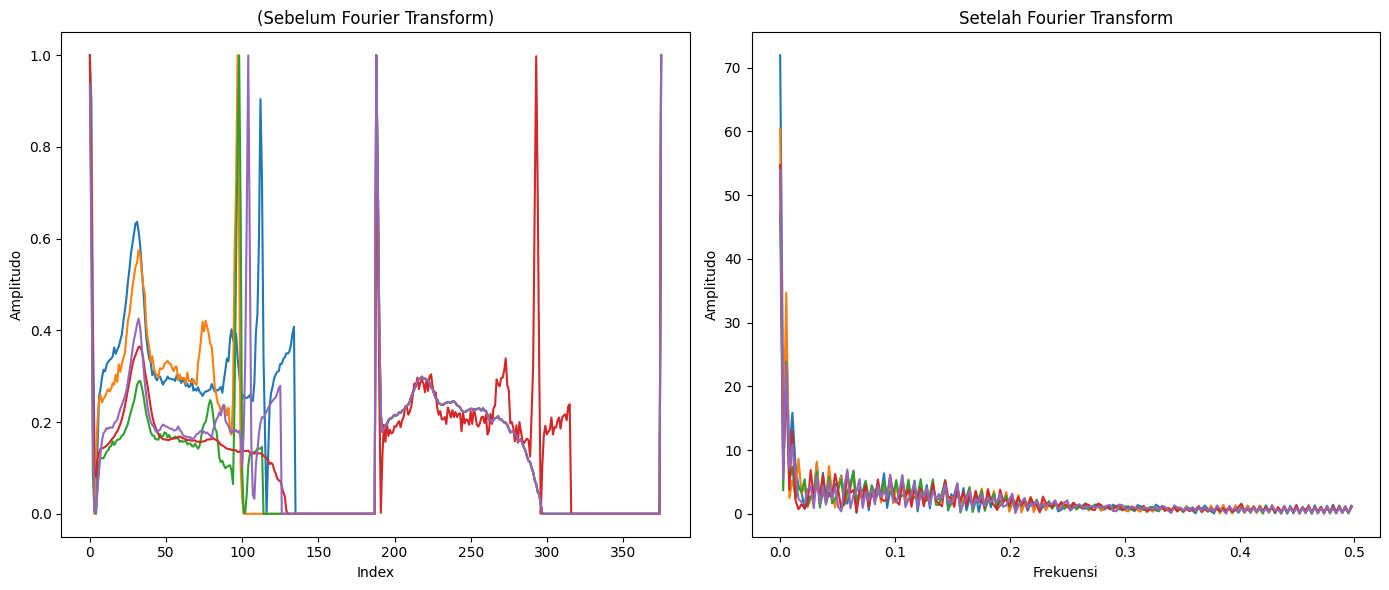

In [14]:
# Visualisasi Sinyal Asli dan Hasil Fourier Transform

# 1. Plot beberapa sinyal asli dari data training sebelum Fourier Transform
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # Subplot untuk sinyal asli

for i in range(5):  # Mengambil 5 contoh sinyal pertama
    signal = train_data.iloc[i].drop('target').values  # Menghapus kolom target untuk mengambil sinyal
    plt.plot(signal, label=f'Sinyal {i+1}')
    
plt.title("(Sebelum Fourier Transform)")
plt.xlabel("Index")
plt.ylabel("Amplitudo")
# plt.legend()

# 2. Plot spektra frekuensi setelah Fourier Transform
plt.subplot(1, 2, 2)  # Subplot untuk spektra frekuensi
sampling_rate = 1.0  # Frekuensi sampling (sesuaikan jika diperlukan)

for i in range(5):  # Mengambil 5 contoh sinyal pertama
    signal = train_data.iloc[i].drop('target').values
    N = len(signal)  # Panjang sinyal
    fft_values = np.abs(fft(signal))  # Magnitude dari Fourier Transform
    frequencies = fftfreq(N, d=1/sampling_rate)[:N//2]  # Frekuensi positif

    # Plot magnitude terhadap frekuensi
    plt.plot(frequencies, fft_values[:N//2], label=f'Sinyal {i+1}')

plt.title("Setelah Fourier Transform")
plt.xlabel("Frekuensi")
plt.ylabel("Amplitudo")
# plt.legend()

plt.tight_layout()
plt.show()

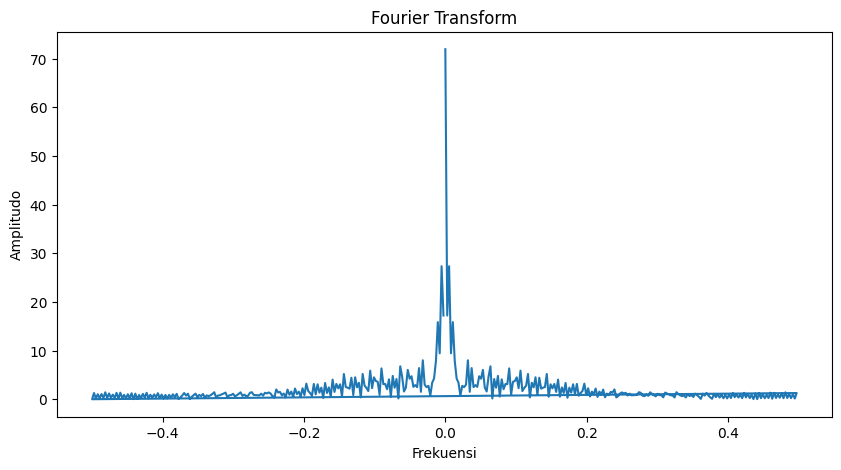

In [15]:
# Memilih contoh sinyal dari data training (misalnya, baris pertama)
example_signal = train_data.iloc[0].drop('target').values

# Melakukan Fourier Transform pada sinyal contoh
fft_values = np.abs(fft(example_signal))

# Menyiapkan data frekuensi untuk plot
frequencies = np.fft.fftfreq(len(fft_values))

# Menampilkan grafik Fourier Transform
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fft_values)
plt.title("Fourier Transform")
plt.xlabel("Frekuensi")
plt.ylabel("Amplitudo")
plt.show()


### Ekstraksi Fitur GLCM (Gray Level Co-occurrence Matrix)

In [16]:
# Fungsi untuk ekstraksi fitur statistik dasar
def extract_basic_stats(signal):
    mean = np.mean(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return mean, std_dev, skewness, kurt

In [17]:
# Menerapkan ekstraksi fitur dasar pada data training
basic_train_features = []
for _, row in train_data.iterrows():
    signal = row.drop('target').values  # Menghapus kolom target untuk mengambil sinyal
    mean, std_dev, skewness, kurt = extract_basic_stats(signal)
    basic_train_features.append([mean, std_dev, skewness, kurt, row['target']])

# Membuat DataFrame untuk hasil ekstraksi fitur dasar pada training
columns = ['mean', 'std_dev', 'skewness', 'kurtosis', 'target']
train_basic_data = pd.DataFrame(basic_train_features, columns=columns)


In [18]:
# Menerapkan ekstraksi fitur dasar pada data testing
basic_test_features = []
for _, row in test_data.iterrows():
    signal = row.drop('target').values  # Menghapus kolom target untuk mengambil sinyal
    mean, std_dev, skewness, kurt = extract_basic_stats(signal)
    basic_test_features.append([mean, std_dev, skewness, kurt, row['target']])

# Membuat DataFrame untuk hasil ekstraksi fitur dasar pada testing
test_basic_data = pd.DataFrame(basic_test_features, columns=columns)

# Menampilkan beberapa baris hasil ekstraksi statistik dasar dari data training
print("Data training setelah ekstraksi fitur statistik dasar:")
print(train_basic_data)

Data training setelah ekstraksi fitur statistik dasar:
          mean   std_dev  skewness   kurtosis  target
0     0.191308  0.183113  1.184482   2.902195     0.0
1     0.160507  0.181623  1.467793   3.716140     0.0
2     0.125754  0.151344  2.603215  11.540327     0.0
3     0.145531  0.146963  2.460903  11.524476     1.0
4     0.143472  0.151604  2.092899   9.028080     0.0
...        ...       ...       ...        ...     ...
6467  0.122463  0.148590  2.480043  10.888790     1.0
6468  0.200156  0.176584  1.342667   3.812876     0.0
6469  0.120052  0.150653  2.887066  12.796754     0.0
6470  0.161968  0.160404  1.848190   7.459415     0.0
6471  0.166825  0.196038  1.804800   4.407252     1.0

[6472 rows x 5 columns]


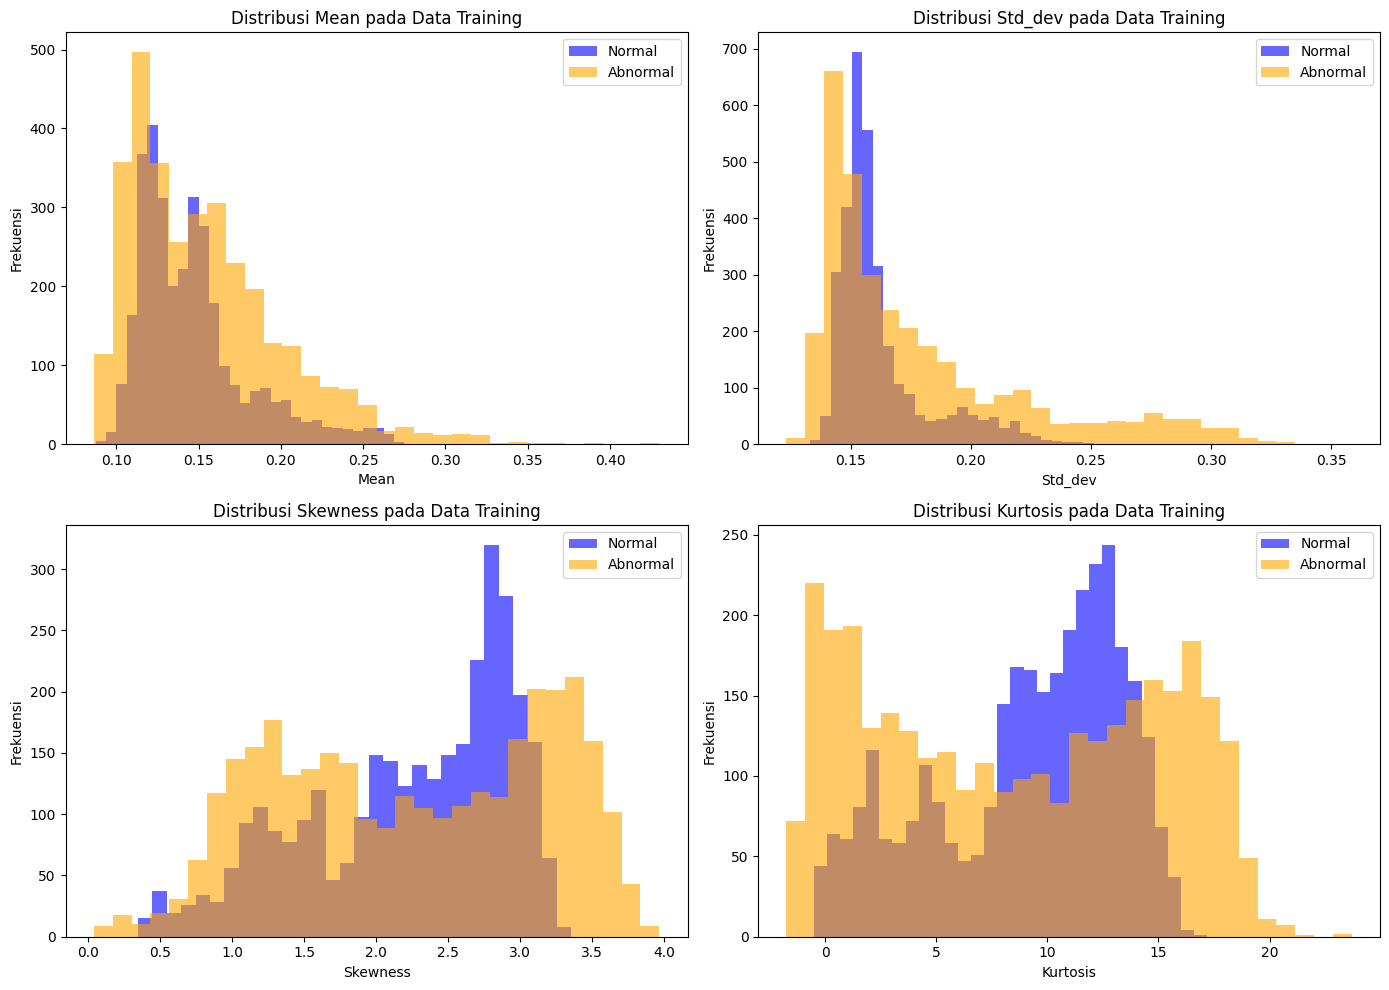

In [19]:
# Membuat histogram untuk masing-masing fitur statistik dasar
features = ['mean', 'std_dev', 'skewness', 'kurtosis']
plt.figure(figsize=(14, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.hist(train_basic_data[train_basic_data['target'] == 0][feature], bins=30, alpha=0.6, label='Normal', color='blue')
    plt.hist(train_basic_data[train_basic_data['target'] == 1][feature], bins=30, alpha=0.6, label='Abnormal', color='orange')
    plt.xlabel(feature.capitalize())
    plt.ylabel("Frekuensi")
    plt.title(f"Distribusi {feature.capitalize()} pada Data Training")
    plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Memisahkan fitur dan target pada data training dan testing
X_train = train_basic_data.drop('target', axis=1)
y_train = train_basic_data['target']
X_test = test_basic_data.drop('target', axis=1)
y_test = test_basic_data['target']

# Membuat dan melatih model K-NN dengan K=3
knn_model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_model.fit(X_train, y_train)

# Memprediksi kelas pada data testing
y_pred = knn_model.predict(X_test)

# Evaluasi Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[642 167]
 [269 540]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.79      0.75       809
         1.0       0.76      0.67      0.71       809

    accuracy                           0.73      1618
   macro avg       0.73      0.73      0.73      1618
weighted avg       0.73      0.73      0.73      1618


Accuracy: 0.73053152039555


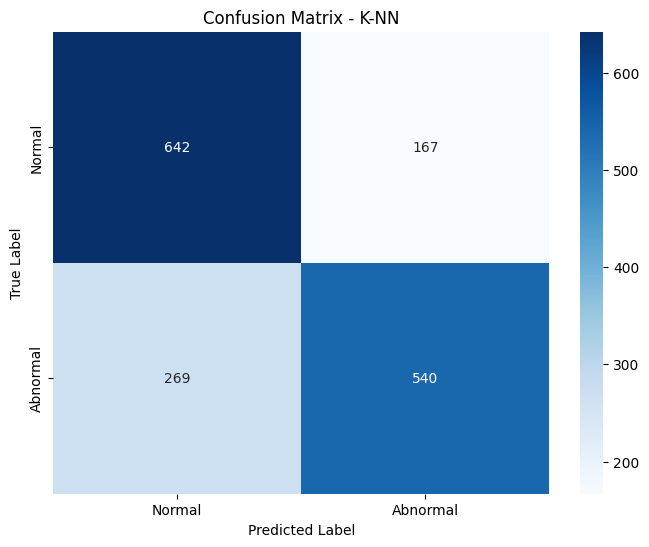

<Figure size 1000x600 with 0 Axes>

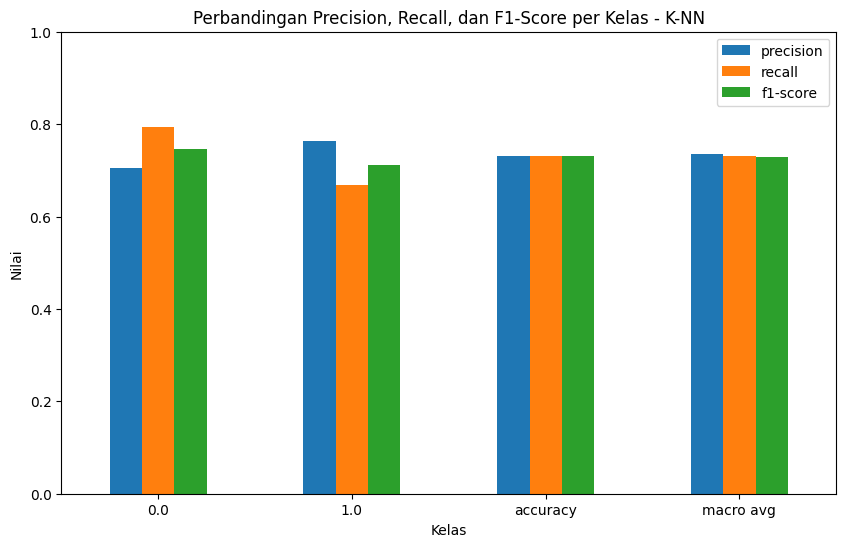

Akurasi: 0.73053152039555


In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - K-NN")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plotting the Metrics
plt.figure(figsize=(10, 6))
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title("Perbandingan Precision, Recall, dan F1-Score per Kelas - K-NN")
plt.ylabel("Nilai")
plt.xlabel("Kelas")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.show()

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", accuracy)

In [22]:
# Membuat dan melatih model Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # max_depth ditentukan agar pohon tidak terlalu dalam
dt_model.fit(X_train, y_train)

# Memprediksi kelas pada data testing
y_pred_dt = dt_model.predict(X_test)

# Evaluasi Model
print("Confusion Matrix - Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report - Decision Tree:")
print(classification_report(y_test, y_pred_dt))
print("\nAccuracy - Decision Tree:", accuracy_score(y_test, y_pred_dt))

Confusion Matrix - Decision Tree:
[[653 156]
 [322 487]]

Classification Report - Decision Tree:
              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73       809
         1.0       0.76      0.60      0.67       809

    accuracy                           0.70      1618
   macro avg       0.71      0.70      0.70      1618
weighted avg       0.71      0.70      0.70      1618


Accuracy - Decision Tree: 0.7045735475896168


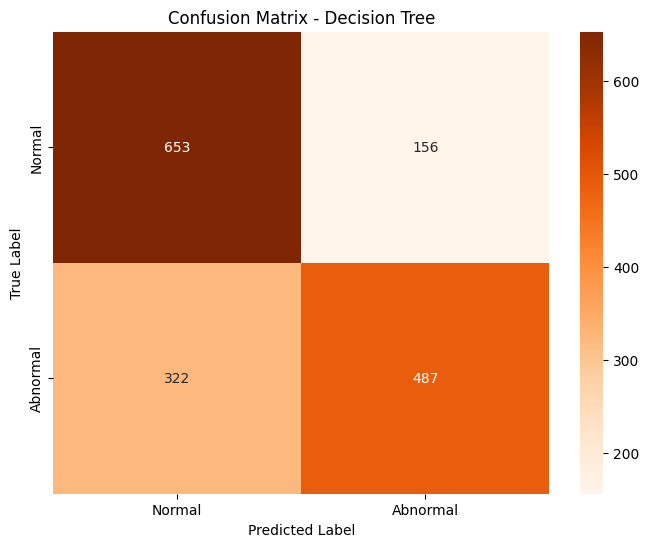

<Figure size 1000x600 with 0 Axes>

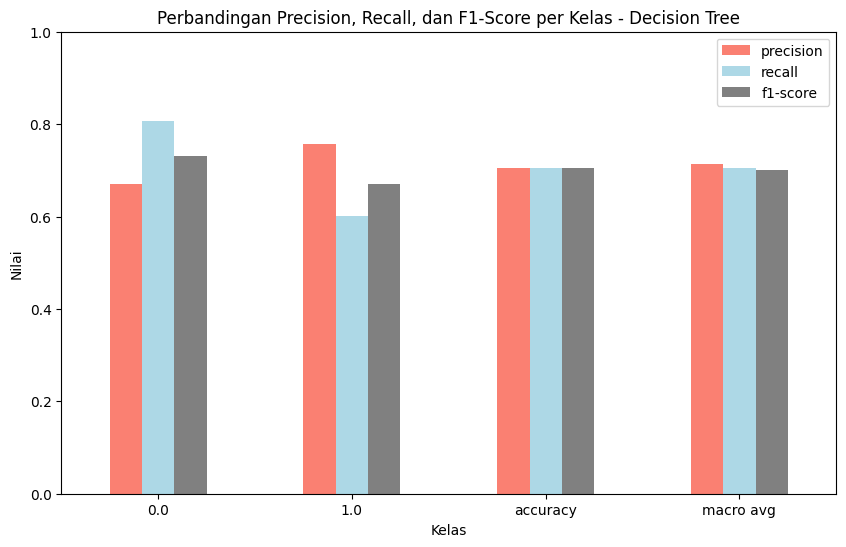

Akurasi - Decision Tree: 0.7045735475896168


In [23]:
# Confusion Matrix untuk Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Oranges", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Classification Report untuk Decision Tree
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
report_df_dt = pd.DataFrame(report_dt).transpose()

# Plotting the Metrics
plt.figure(figsize=(10, 6))
report_df_dt[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6), color=['salmon', 'lightblue', 'gray'])
plt.title("Perbandingan Precision, Recall, dan F1-Score per Kelas - Decision Tree")
plt.ylabel("Nilai")
plt.xlabel("Kelas")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.show()

# Print Akurasi
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Akurasi - Decision Tree:", accuracy_dt)

## Conclusion
1. K-Nearest Neighbours (K-NN):
Accuracy: 73%
K-NN is slightly better at recognising Normal and Abnormal condition patterns in this data.
Suitable for better detection of abnormal conditions.

2. Decision Tree:
Accuracy: 70%
Decision Tree provides results that can be explained in easy-to-understand ‘if-then’ rules.
Suitable if you want to understand the decision logic of each prediction.

### **General Conclusion:**
Use K-NN if you want more accurate abnormal detection.
Use Decision Tree if you need an easy-to-understand explanation of each decision.